## read index from mysql

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import os

import pymysql
from warnings import filterwarnings

_connection = None

def get_connection(db_config):
    """
    get db connection
    :return:
    """
    global _connection
    if _connection is None:
        _connection = pymysql.connect(host=db_config['host'], user=db_config['username'],
                                      password=db_config['password'],
                                      db=db_config['db'], charset="utf8")
        filterwarnings('ignore', category=pymysql.Warning)

    return _connection


def close():
    """
    close DB connection
    :return:
    """
    global _connection
    if _connection is not None:
        _connection.close()
    _connection = None

In [3]:
db = {
    'host': '172.26.187.242',
    'username': 'malware_r',
    'password': 'GEg22v2O7jbfWhb3',
    'db': 'malware'
}

In [27]:
import time

def get_specific_data(table_suffix, sql=None):
    start_time = time.time()
    
    global _connection
    if _connection is None:
        raise Exception("please init db connect first")

    cursor = _connection.cursor()
    cursor.execute("SET NAMES utf8mb4")

    ret = []
    
    sql1 = """
select
  a.mw_file_hash,
  a.section_name,
  c.mw_file_suffix as mw_file_size,
  c.mw_file_prefix as mw_file_directory,
  c.mw_num_engines,
  a.pointerto_raw_data,
  a.virtual_size,
  d.mw_em_f
from mw_index_2017_section_%s as a
  right join mw_index_2017_%s c on a.mw_file_hash = c.mw_file_hash
  right join mw_index_2017_feature_%s d on a.mw_file_hash = d.mw_file_hash
where a.section_name = '.text' and c.mw_num_engines <> -1 and (c.mw_num_engines > 8 or c.mw_num_engines < 4) and
      c.mw_file_prefix in ('201701')
group by mw_file_hash
    """ % (table_suffix, table_suffix, table_suffix)
        
    
    sql2 = """
select
  b.mw_file_hash,
  b.mw_file_prefix as mw_file_directory,
  b.mw_file_suffix as mw_file_size,
  b.mw_num_engines,
  a.section_name,
  a.virtual_size,
  a.pointerto_raw_data,
  c.mw_em_f
from mw_index_2017_section_%s a
  inner join mw_index_2017_%s b on a.mw_file_hash = b.mw_file_hash
  inner join mw_index_2017_feature_%s c on a.mw_file_hash = c.mw_file_hash
where MEM_EXECUTE = 1 and (mw_num_engines >= 8 or mw_num_engines = 0) and mw_num_engines <> -1
      and mw_file_prefix in ('201701')
group by b.mw_file_hash;
    """ % (table_suffix, table_suffix, table_suffix)
    
    
    sql3 = """
select
  mw_file_hash,
  mw_file_prefix as mw_file_directory,
  mw_file_suffix as mw_file_size,
  mw_num_engines
from mw_index_2017_%s
where (mw_num_engines > 8 or mw_num_engines < 4) and mw_num_engines <> -1
      and mw_file_prefix in ('201705');
    """ % table_suffix
        
        
    sql4 = """
select
  b.mw_file_hash,
  mw_file_prefix as mw_file_directory,
  mw_file_suffix as mw_file_size,
  mw_num_engines,
  a.virtual_size,
  a.pointerto_raw_data
from mw_index_2017_section_%s a
  inner join mw_index_2017_%s b on a.mw_file_hash = b.mw_file_hash
where (mw_num_engines >= 8 or mw_num_engines = 0) and mw_num_engines <> -1
      and mw_file_prefix in ('201701')
group by b.mw_file_hash;
    """ % (table_suffix, table_suffix)
        
    sql5 = """
select
  a.mw_file_hash,
  c.mw_file_prefix as mw_file_directory,
  c.mw_file_suffix as mw_file_size,
  c.mw_num_engines,
  b.section_name,
  b.virtual_size,
  b.pointerto_raw_data,
  d.mw_em_f
from (select
        mw_file_hash,
        section_name,
        count(1) as cnt
      from mw_index_2017_section_%s
      where section_name = '.text' and pointerto_raw_data <> 0
      group by mw_file_hash, section_name) a inner join mw_index_2017_section_%s b
    on a.mw_file_hash = b.mw_file_hash and a.cnt = 1 and b.section_name = '.text'
  inner join mw_index_2017_%s c on a.mw_file_hash = c.mw_file_hash and (c.mw_num_engines > 8 or c.mw_num_engines = 0) and c.mw_num_engines<> -1 and c.mw_file_prefix = '201701'
  inner join mw_index_2017_feature_%s d on a.mw_file_hash = d.mw_file_hash
    """ % (table_suffix, table_suffix, table_suffix, table_suffix)
    
    if sql is None:
        sql = sql5
    cursor.execute(sql)

    field_names = [i[0] for i in cursor.description]

    for row in cursor:
        temp = {}
        for key in range(len(row)):
            temp[field_names[key]] = row[key]
        ret.append(temp)
     
    cursor.close()
    # _connection.close()
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return ret

In [28]:
close()
res = []
get_connection(db)
table_suffix = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
for suffix in table_suffix:
    res.extend(get_specific_data(suffix))
close()
print(len(res))

--- 7.133002519607544 seconds ---
--- 10.563770055770874 seconds ---
--- 8.619175434112549 seconds ---
--- 8.970360040664673 seconds ---
--- 9.234475135803223 seconds ---
--- 9.533116340637207 seconds ---
--- 9.597068548202515 seconds ---
--- 9.243732213973999 seconds ---
--- 8.13450002670288 seconds ---
--- 9.975507736206055 seconds ---
--- 9.54612398147583 seconds ---
--- 9.939478397369385 seconds ---
--- 9.381024360656738 seconds ---
--- 9.055209159851074 seconds ---
--- 8.604273319244385 seconds ---
--- 8.617358684539795 seconds ---
114436


## check and split data

In [29]:
import pandas as pd
data = pd.DataFrame(res)

In [30]:
data.head()

,mw_em_f,mw_file_directory,mw_file_hash,mw_file_size,mw_num_engines,pointerto_raw_data,section_name,virtual_size
0,0.30814531445503235;0.004307170398533343;0.003...,201701,0000A3EAB7F06DB29113F7BDE61328D56BC874B16DD895...,_339434,11,1024,.text,13352
1,0.013131157495081423;0.004108430817723274;0.00...,201701,00015BCA398B78199C5442DB5B28D14405549FB135FA69...,_2098368,0,1024,.text,25467
2,0.04739173501729965;0.006257581990212202;0.004...,201701,0001A015A6A97803F557AA84E9606DA2FA7E56E1207FAA...,_177225,10,1024,.text,13352
3,0.3064397275447845;0.0044606528244912624;0.003...,201701,000224C4A60B9A3489D16B5F67DEF609EBA09087D12645...,_336722,10,1024,.text,13352
4,0.1969459056854248;0.003335272427648306;0.0034...,201701,00024A23DC68300349FB342CD1066D195CCA4045744958...,_103140,12,512,.text,77824


(92888, 8)


/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


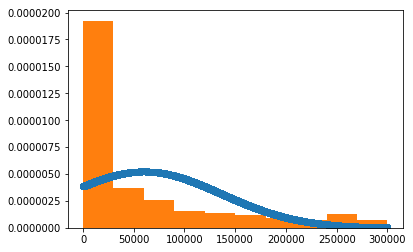

In [31]:
import numpy as np
import scipy.stats as stats
import pylab as pl

clean_data = data.loc[data.virtual_size <= 300000]
clean_data = clean_data.reset_index(drop=True)

print(clean_data.shape)

h = sorted(clean_data.virtual_size.ravel())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()                   #use may also need add this 

In [32]:
clean_data.mw_num_engines[clean_data.mw_num_engines < 4 ] = 0
clean_data.mw_num_engines[clean_data.mw_num_engines > 4 ] = 1
label = clean_data.mw_num_engines.ravel()
label

/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1, 0, 1, ..., 0, 0, 0])

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(clean_data, label, test_size=0.1, random_state=1234)

max_length = max(x_train.virtual_size.ravel())


In [33]:
max_length = 300000

x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

# Mal Conv

In [34]:
import keras
import numpy as np

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, datasets, labels, batch_size=32, dim=8192, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.datasets = datasets
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.dim), dtype=float)
        y = np.zeros(self.batch_size, dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            base_path = "/ssd/2017/{0}/{1}{2}"
            item = self.datasets.loc[ID]
            file_path = base_path.format(item["mw_file_directory"], item["mw_file_hash"], item["mw_file_size"])
            in_file = open(file_path, 'rb')
            in_file.seek(item['pointerto_raw_data'])
            bytes_data = [int(single_byte) for single_byte in in_file.read(item['virtual_size'])]
            X[i, 0:len(bytes_data)] = bytes_data
            y[i] = self.labels[ID]

        return X, y

In [35]:
import hashlib
import json
import time

import keras
from keras import Input
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Dense, Embedding, Conv1D, Multiply, GlobalMaxPooling1D
from keras.models import load_model
from sklearn.model_selection import train_test_split

class TMalConv(object):
    """
    train of mal conv
    """

    def __init__(self):
        self.train_df = clean_data
        self.label_df = label
        self.v_x = None
        self.v_y = None
        self.max_len = max_length
        self.history = None
        self.model = None
        self.p_md5 = None
        self.summary = {
            'time':time.time(),
            'batch_size': 32,
            'epochs': 16,
            's_test_size': 0.05,
            's_random_state': 5242,
            'g_c_filter': 128,
            'g_c_kernel_size': 500,
            'g_c_stride': 500,
        }

    def run(self):
        """
        :return:
        """
        self.train()
        
    def get_p(self, key):
        """
        get the parameter from the summary
        :param key:
        :return:
        """
        return self.summary[key]

    def gate_cnn(self, gate_cnn_input):
        """
        construct a gated cnn by the specific kernel size
        :param gate_cnn_input:
        :param kernel_size:
        :return:
        """
        conv1_out = Conv1D(self.get_p("g_c_filter"), self.get_p("g_c_kernel_size"), strides=self.get_p("g_c_stride"))(
            gate_cnn_input)
        conv2_out = Conv1D(self.get_p("g_c_filter"), self.get_p("g_c_kernel_size"), strides=self.get_p("g_c_stride"),
                           activation="sigmoid")(gate_cnn_input)
        merged = Multiply()([conv1_out, conv2_out])
        gate_cnn_output = GlobalMaxPooling1D()(merged)
        return gate_cnn_output

    def get_model(self):
        """
        get a model
        :param max_len:
        :param kernel_sizes:
        :return:
        """
        net_input = Input(shape=(self.max_len,))

        embedding_out = Embedding(256, 8, input_length=self.max_len)(net_input)
        merged = self.gate_cnn(embedding_out)

        dense_out = Dense(128)(merged)
        net_output = Dense(1, activation='sigmoid')(dense_out)

        model = keras.models.Model(inputs=net_input, outputs=net_output)

        return model

    def train(self):
        batch_size = self.get_p("batch_size")
        epochs = self.get_p("epochs")

        self.model = self.get_model()

        partition_train, partition_validation = train_test_split(range(len(self.train_df)), test_size=0.05, random_state=1234)
        print('Length of the train: ', len(partition_train))
        print('Length of the validation: ', len(partition_validation))
        
#         tensor_board = TensorBoard(log_dir='./logs/', batch_size=batch_size)
        file_path = "/home/zhaoqi/BaseTrain/models/{epoch:04d}-{val_loss:.5f}-{val_acc:.5f}.h5"
#         early_stopping = EarlyStopping("val_loss", patience=2, verbose=0, mode='auto')
        check_point = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
        callbacks_list = [check_point]

        # Generators
        training_generator = DataGenerator(partition_train, self.train_df, self.label_df, batch_size, self.max_len)
        validation_generator = DataGenerator(partition_validation, self.train_df, self.label_df, batch_size, self.max_len)

        self.model.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

        self.model.fit_generator(generator=training_generator,
                                 validation_data=validation_generator,
                                 use_multiprocessing=True,
                                 epochs=epochs,
                                 workers=6,
                                 callbacks=callbacks_list)

In [70]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = False
set_session(tf.Session(config=config))
 

In [71]:
t_instance = TMalConv()
t_instance.run()

Length of the train:  88243
Length of the validation:  4645
Epoch 1/16


Process ForkPoolWorker-290:
Process ForkPoolWorker-292:
Process ForkPoolWorker-293:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/zhaoqi

KeyboardInterrupt: 

Process ForkPoolWorker-291:
Traceback (most recent call last):
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/queues.py", line 341, in put
    obj = ForkingPickler.dumps(obj)
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/reduction.py", line 50, in dumps
    cls(buf, protocol).dump(obj)
KeyboardInterrupt
Process ForkPoolWorker-289:
Process ForkPoolWorker-294:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home

In [64]:
close()
res = []
get_connection(db)
table_suffix = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
for suffix in table_suffix:
    sql = """
select
  a.mw_file_hash,
  c.mw_file_prefix as mw_file_directory,
  c.mw_file_suffix as mw_file_size,
  c.mw_num_engines,
  b.section_name,
  b.virtual_size,
  b.pointerto_raw_data,
  d.mw_em_f
from (select
        mw_file_hash,
        section_name,
        count(1) as cnt
      from mw_index_2017_section_%s
      where section_name = '.text' and pointerto_raw_data <> 0
      group by mw_file_hash, section_name) a inner join mw_index_2017_section_%s b
    on a.mw_file_hash = b.mw_file_hash and a.cnt = 1 and b.section_name = '.text'
  inner join mw_index_2017_%s c on a.mw_file_hash = c.mw_file_hash and (c.mw_num_engines > 8 or c.mw_num_engines = 0) and c.mw_num_engines<> -1 and c.mw_file_prefix = '201705'
  inner join mw_index_2017_feature_%s d on a.mw_file_hash = d.mw_file_hash
    """ % (suffix, suffix, suffix, suffix)
    res.extend(get_specific_data(suffix, sql))
close()

print(len(res))
import pandas as pd
test_data = pd.DataFrame(res)
test_data.mw_num_engines[test_data.mw_num_engines < 4 ] = 0
test_data.mw_num_engines[test_data.mw_num_engines > 8 ] = 1
test_data.virtual_size[test_data.virtual_size > 300000 ] = 300000
test_label = test_data.mw_num_engines.ravel()

--- 8.589596509933472 seconds ---
--- 5.837661504745483 seconds ---
--- 5.919601917266846 seconds ---
--- 8.339919567108154 seconds ---
--- 8.987675666809082 seconds ---
--- 9.96890640258789 seconds ---
--- 43.35040330886841 seconds ---
--- 9.26111102104187 seconds ---
--- 7.6259543895721436 seconds ---
--- 9.892730951309204 seconds ---
--- 9.268390655517578 seconds ---
--- 9.77153205871582 seconds ---
--- 9.294157028198242 seconds ---
--- 8.936628580093384 seconds ---
--- 8.470808744430542 seconds ---
--- 9.085030794143677 seconds ---
66833


/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/zhaoqi/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
sum(test_data.mw_num_engines)

0

In [66]:
model_dir = '/home/zhaoqi/BaseTrain/models/'
f_name = '0001-0.09768-0.96832.h5'
c_model = load_model(model_dir + f_name)
test_generator = DataGenerator(range(len(test_data)), test_data, test_label, 16, max_length, False)
y_pred = c_model.predict_generator(generator=test_generator, max_queue_size=10, workers=6, use_multiprocessing=True, verbose=1)

4177/4177 [==============================] - 929s 222ms/step


In [46]:
len(y_pred)

80976

# Estimate

In [67]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix

def estimate_model(y_pred, test_y):
    
    loss = log_loss(test_y, y_pred)
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y, (y_pred > 0.5).astype(int))
    print("loss : %.5f" % loss)
    print("auc score : %.5f" % auc)
    print("accuracy score : %.5f" % acc)

    fp_np_index = np.where(test_y == 0)
    fp_np = y_pred[fp_np_index].shape[0]
    thre_index = int(np.ceil(fp_np - fp_np * 0.001))

    sorted_pred_prob = np.sort(y_pred[fp_np_index], axis=0)
    thre = sorted_pred_prob[thre_index]
    if thre == 1:
        thre = max(sorted_pred_prob[np.where(sorted_pred_prob != 1)])

    y_pred_prob = np.vstack((y_pred.transpose(), (1 - y_pred).transpose())).transpose()
    y_pred_prob[:, 1] = thre
    y_pred_label = np.argmin(y_pred_prob, axis=-1)

    tn, fp, fn, tp = confusion_matrix(test_y, y_pred_label).ravel()
    fp_rate = fp / (fp + tn)
    recall_rate = tp / (tp + fn)

    print("thre: %.5f"%  thre)
    print("fp:  %.5f"%  fp_rate)
    print("recall:  %.5f"%  recall_rate)
    
    return auc, loss, recall_rate

In [48]:
estimate_model(y_pred, test_label[0:len(y_pred)])

loss : 0.27254
auc score : 0.97695
accuracy score : 0.92862
thre: 0.99990
fp:  0.00046
recall:  0.02559


(0.9769503832481158, 0.27254251131120455, 0.025588981515041683)

# EMBER

In [49]:
import pandas as pd
import re
import hashlib
import numpy as np
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [50]:
def get_ember_feature(data):
    ember_f = np.zeros((len(data.mw_em_f), 2351), dtype=float)
    for index, item in data.iterrows():
        float_arr = item['mw_em_f'].split(';')
        ember_f[index, :] = float_arr
    return ember_f

## ember train data

In [51]:
def get_model(data, label):
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.05, random_state=1234)
    params = {'application': 'binary'}
    lgbm_dataset = lgb.Dataset(x_train, y_train.ravel())
    valid_sets = lgb.Dataset(x_test, y_test.ravel())

    model = lgb.train(params, lgbm_dataset, 100000, valid_sets=valid_sets, early_stopping_rounds=10)
    y_pred = model.predict(x_test)
    
    loss = log_loss(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
#     model.save_model(file_path + "-%04d-%.5f-%.5f.h5" % (model.best_iteration, loss, acc),
#                      num_iteration=model.best_iteration)
    print("val loss : %.5f" % loss)
    print("auc score : %.5f" % auc)
    print("accuracy score : %.5f" % acc)
        
    return model

In [52]:
X_ember_train = get_ember_feature(clean_data)
y_ember_train = label

In [53]:
X_ember_train.shape

(92888, 2351)

In [54]:
import matplotlib.pyplot as plt
model = get_model(X_ember_train, y_ember_train)

[1]	valid_0's binary_logloss: 0.606233
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.537826
[3]	valid_0's binary_logloss: 0.480339
[4]	valid_0's binary_logloss: 0.431923
[5]	valid_0's binary_logloss: 0.389776
[6]	valid_0's binary_logloss: 0.353776
[7]	valid_0's binary_logloss: 0.322141
[8]	valid_0's binary_logloss: 0.294377
[9]	valid_0's binary_logloss: 0.269424
[10]	valid_0's binary_logloss: 0.247498
[11]	valid_0's binary_logloss: 0.228327
[12]	valid_0's binary_logloss: 0.211152
[13]	valid_0's binary_logloss: 0.195619
[14]	valid_0's binary_logloss: 0.181896
[15]	valid_0's binary_logloss: 0.16947
[16]	valid_0's binary_logloss: 0.158507
[17]	valid_0's binary_logloss: 0.148432
[18]	valid_0's binary_logloss: 0.138745
[19]	valid_0's binary_logloss: 0.130418
[20]	valid_0's binary_logloss: 0.123048
[21]	valid_0's binary_logloss: 0.116106
[22]	valid_0's binary_logloss: 0.109956
[23]	valid_0's binary_logloss: 0.103742
[24]	valid_0's binary_loglos

[199]	valid_0's binary_logloss: 0.015578
[200]	valid_0's binary_logloss: 0.0155223
[201]	valid_0's binary_logloss: 0.0154496
[202]	valid_0's binary_logloss: 0.0154418
[203]	valid_0's binary_logloss: 0.0153582
[204]	valid_0's binary_logloss: 0.0153573
[205]	valid_0's binary_logloss: 0.0153465
[206]	valid_0's binary_logloss: 0.0153817
[207]	valid_0's binary_logloss: 0.0153812
[208]	valid_0's binary_logloss: 0.0154231
[209]	valid_0's binary_logloss: 0.0153892
[210]	valid_0's binary_logloss: 0.0153721
[211]	valid_0's binary_logloss: 0.0153591
[212]	valid_0's binary_logloss: 0.015348
[213]	valid_0's binary_logloss: 0.0153257
[214]	valid_0's binary_logloss: 0.0152787
[215]	valid_0's binary_logloss: 0.0152673
[216]	valid_0's binary_logloss: 0.0152152
[217]	valid_0's binary_logloss: 0.0152369
[218]	valid_0's binary_logloss: 0.015279
[219]	valid_0's binary_logloss: 0.0152846
[220]	valid_0's binary_logloss: 0.0152929
[221]	valid_0's binary_logloss: 0.0152901
[222]	valid_0's binary_logloss: 0.015

## Ember test data

In [55]:
X_ember_test = get_ember_feature(test_data)
y_ember_test = test_label

In [68]:
y_p = model.predict(X_ember_test)
y_pred_e = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred_e[i, 0] = y_p[i]

estimate_model(y_pred_e, y_ember_test)

loss : 0.19203
auc score : 0.98884
accuracy score : 0.96986
thre: 1.00000
fp:  0.00098
recall:  0.14757


(0.9888434603901384, 0.19202686913604602, 0.1475683119518736)

# Mal Conv + Ember

get 128 features from the last layers of Malconv

In [58]:
from keras.models import Model

model_f = Model(c_model.input, c_model.layers[-2].output)

train_generator = DataGenerator(range(len(clean_data)), clean_data, label, 16, max_length, False)
malcon_train_x = model_f.predict_generator(generator=train_generator, max_queue_size=10, workers=6, use_multiprocessing=True, verbose=1)

test_generator = DataGenerator(range(len(test_data)), test_data, test_label, 16, max_length, False)
malcon_test_x = model_f.predict_generator(generator=test_generator, max_queue_size=10, workers=6, use_multiprocessing=True, verbose=1)

5061/5061 [==============================] - 1451s 287ms/step


## merge mal conv and ember *train* data

In [59]:
num = len(malcon_train_x)
ebm_X = np.zeros((num, 2351+128), dtype=float)
ebm_y = np.zeros(num, dtype=float)

for index in range(num):
    ebm_X[index, 0:2351] = X_ember_train[index]
    ebm_X[index, 2351:2351+128] = malcon_train_x[index]
    ebm_y[index] = y_ember_train[index]

import matplotlib.pyplot as plt
model_m = get_model(ebm_X, ebm_y)

[1]	valid_0's binary_logloss: 0.598871
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.524257
[3]	valid_0's binary_logloss: 0.461943
[4]	valid_0's binary_logloss: 0.409495
[5]	valid_0's binary_logloss: 0.364785
[6]	valid_0's binary_logloss: 0.326203
[7]	valid_0's binary_logloss: 0.292764
[8]	valid_0's binary_logloss: 0.263572
[9]	valid_0's binary_logloss: 0.237854
[10]	valid_0's binary_logloss: 0.215196
[11]	valid_0's binary_logloss: 0.195019
[12]	valid_0's binary_logloss: 0.17755
[13]	valid_0's binary_logloss: 0.161864
[14]	valid_0's binary_logloss: 0.148007
[15]	valid_0's binary_logloss: 0.135492
[16]	valid_0's binary_logloss: 0.124528
[17]	valid_0's binary_logloss: 0.114605
[18]	valid_0's binary_logloss: 0.105775
[19]	valid_0's binary_logloss: 0.0978768
[20]	valid_0's binary_logloss: 0.0907353
[21]	valid_0's binary_logloss: 0.0842877
[22]	valid_0's binary_logloss: 0.0786998
[23]	valid_0's binary_logloss: 0.0736948
[24]	valid_0's binary_l

## merge mal conv and ember *test* data

In [60]:
num = len(malcon_test_x)
ebm_X_t = np.zeros((num, 2351+128), dtype=float)
ebm_y_t = np.zeros(num, dtype=float)

for index in range(num):
    ebm_X_t[index, 0:2351] = X_ember_test[index]
    ebm_X_t[index, 2351:2351+128] = malcon_test_x[index]
    ebm_y_t[index] = y_ember_test[index]

In [69]:
y_p = model_m.predict(ebm_X_t)
y_pred = np.zeros((len(y_p), 1))
for i in range(len(y_p)):
    y_pred[i, 0] = y_p[i]

estimate_model(y_pred, ebm_y_t)

loss : 0.23710
auc score : 0.98685
accuracy score : 0.95919
thre: 0.99999
fp:  0.00094
recall:  0.14455


(0.9868454588327674, 0.2370990382658855, 0.14454512504530628)